<a href="https://colab.research.google.com/github/ElektrosStulpas/QuantumRNN-BachelorsVU/blob/main/QRNNimplementationEightDayGradEverySample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install needed libraries

In [1]:
!pip install qiskit[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

Data preparation

In [2]:
from google.colab import drive
import pandas as pd
import os
import numpy as np

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
SPY_5YEAR_DAILY = 'duomenys_yahoo_SPY_20220424.csv'
root_path = "/content/drive/MyDrive/QRNNData"

def load_stock_data_from_drive(root_path, data_file_name):
  data = pd.read_csv(os.path.join(root_path, SPY_5YEAR_DAILY))
  return data

def save_params_to_drive(root_path, file_name, params):
  np.save(os.path.join(root_path, file_name), params)

def load_params_from_drive(root_path, file_name):
  return np.load(os.path.join(root_path, file_name))

In [5]:
#currently data passed in as series and passed out as series
def rescale_data(data, new_scale_from, new_scale_to, maxmin):
  #NORMALIZATION FORMULA from https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
  rescaled_x = (new_scale_to-new_scale_from) * ((data - maxmin[1]) / ( maxmin[0] - maxmin[1])) + new_scale_from

  return rescaled_x

In [6]:
spy_data = load_stock_data_from_drive(root_path, SPY_5YEAR_DAILY)
close_data = spy_data["Close"]

data_maxmin = max(close_data), min(close_data)

# In the work we're following they mention using 100 data points for training and 80 for test
TRAIN_len = 100
VALID_len = TRAIN_len + 80

inputs_TRAIN = rescale_data(close_data, -1, 1, data_maxmin)[:TRAIN_len]
labels_TRAIN = close_data[:TRAIN_len+1] # taking one more to lengthen the array so we can naturally shift it without losing length

inputs_VALID = rescale_data(close_data, -1, 1, data_maxmin)[TRAIN_len:VALID_len]
labels_VALID = close_data[TRAIN_len:VALID_len+1] # taking one more to lengthen the array so we can naturally shift it without losing length

sequence_size = 7

inputs_TRAIN = np.array([inputs_TRAIN[i:i+sequence_size] for i in range(len(inputs_TRAIN) - sequence_size+1)])
labels_TRAIN = labels_TRAIN[sequence_size:] # sequence_size is 1 too much, thus shifts the data naturally
training_data = list(zip(inputs_TRAIN, labels_TRAIN))

inputs_VALID = np.array([inputs_VALID[i:i+sequence_size] for i in range(len(inputs_VALID) - sequence_size+1)])
labels_VALID = labels_VALID[sequence_size:] # sequence_size is 1 too much, thus shifts the data naturally
validation_data = list(zip(inputs_VALID, labels_VALID))

In [7]:
for input, label in training_data[:2]:
  print(f"{input} {label}")

[-0.88836551 -0.87753174 -0.87870939 -0.87713919 -0.8812215  -0.87651125
 -0.87580462] 238.479996
[-0.87753174 -0.87870939 -0.87713919 -0.8812215  -0.87651125 -0.87580462
 -0.87808134] 238.759995


In [8]:
for input, label in validation_data[:2]:
  print(f"{input} {label}")

[-0.78693673 -0.79400215 -0.78984138 -0.78787875 -0.78717223 -0.79243207
 -0.79203952] 248.929993
[-0.79400215 -0.78984138 -0.78787875 -0.78717223 -0.79243207 -0.79203952
 -0.79604336] 249.080002


In [9]:
print(f"labels_TRAIN len: {len(labels_TRAIN)}, input_TRAIN len: {len(inputs_TRAIN)}, labels_VALID len: {len(labels_VALID)}, input_VALID len: {len(inputs_VALID)}")

labels_TRAIN len: 94, input_TRAIN len: 94, labels_VALID len: 74, input_VALID len: 74


Model

In [10]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi

import numpy as np

In [11]:
#takes input vector of value from -1 to 1, outputs predictions vector in the same value range
class QRNN:
  def __init__(self, q_reg=3, params=None):
    self.qubits_per_reg = q_reg

    if params is not None:
      self.params = params
    else:
       self.params = self.init_random_params()

    self.ansatz = self.construct_ansatz()


  def set_params(self, params):
    self.params = params
    self.ansatz = self.construct_ansatz()

  def get_params(self):
    return self.params


  def forward(self, x_vec):

    QRNN_circuit = QuantumCircuit(self.qubits_per_reg*2)

    QRNN_circuit.reset(list(range(self.qubits_per_reg*2)))

    for idx in range(7):
      QRNN_circuit.reset(list(range(self.qubits_per_reg)))
      encoding_circ = self.construct_enc_circ(x_vec[idx])
      QRNN_circuit.compose(encoding_circ, list(range(self.qubits_per_reg)), inplace=True)

      QRNN_circuit.compose(self.ansatz, inplace=True, wrap=True)


    y_t = self.partial_trace_measure(QRNN_circuit)

    return abs(y_t)


  # def forward_batch(self, x_data):
  #   prediction_vec = []
  #   for x_vec in x_data:
  #     y_hat = self.forward(x_vec)
  #     prediction_vec.append(y_hat)

  #   return np.array(prediction_vec)


  def construct_enc_circ(self, x_val):
    enc_circ = QuantumCircuit(self.qubits_per_reg)

    for qubit in range(self.qubits_per_reg):
      enc_circ.ry(np.arccos(x_val), qubit)

    return enc_circ


  def construct_ansatz(self):
    theta_gamma_params = self.params

    ansatz = QuantumCircuit(self.qubits_per_reg*2)

    qu_indexes = list(range(self.qubits_per_reg*2))
    qu_indexes_rolled = list(range(1, self.qubits_per_reg*2))
    qu_indexes_rolled.append(0)

    for idx in qu_indexes:
      ansatz.rx(theta_gamma_params[idx][0], idx)
      ansatz.rz(theta_gamma_params[idx][1], idx)
      ansatz.rx(theta_gamma_params[idx][2], idx)

    for idx in qu_indexes:
      ansatz.cnot(idx, qu_indexes_rolled[idx])
      ansatz.rz(theta_gamma_params[idx][3], qu_indexes_rolled[idx])
      ansatz.cnot(idx, qu_indexes_rolled[idx])

    return ansatz


  def partial_trace_measure(self, circuit):
    circ_dens_matrix = qi.DensityMatrix.from_instruction(circuit)
    qubits_to_trace_out = list(range(self.qubits_per_reg*2))[1:]

    measured_qubit_rho = qi.partial_trace(circ_dens_matrix, qubits_to_trace_out)

    ket1 = qi.Statevector([0, 1])
    projector1 = ket1.to_operator()

    trimmed_measured_qubit_rho = measured_qubit_rho.evolve(projector1)
    prediction_y = trimmed_measured_qubit_rho.trace()

    return prediction_y


  def init_random_params(self):
    rng = np.random.default_rng()
    theta_gamma_params = np.arccos(rng.uniform(-1, 1, size=(self.qubits_per_reg*2, 4))) #6x3 theta params and 6x1 gamma params
    return theta_gamma_params

In [12]:
# generating random params and saving it to be reused so it would be easier to measure performance with different parameters

# model = QRNN()
# save_params_to_drive(root_path, "6_qubit_params", model.get_params())

In [13]:
qubit_num = 6
rng = np.random.default_rng()
theta_gamma_params = np.arccos(rng.uniform(-1, 1, size=(qubit_num, 4)))

print(theta_gamma_params)

qu_indexes = list(range(qubit_num))
qu_indexes_rolled = list(range(1, qubit_num))
qu_indexes_rolled.append(0)

for idx in qu_indexes:
  print(f"RX: {theta_gamma_params[idx][0]}, RZ: {theta_gamma_params[idx][1]}, RX: {theta_gamma_params[idx][2]} for qubit {idx}")

for idx in qu_indexes:
  print(f"RZ: {theta_gamma_params[idx][3]} gamma on qubit {qu_indexes_rolled[idx]}")

[[2.26072638 2.84467452 1.46623363 2.01019262]
 [1.9543213  1.26985971 1.71712868 2.58407787]
 [0.62891966 0.76005974 2.12883261 2.47888004]
 [1.12319224 1.90550864 0.82462897 0.99933169]
 [2.17749267 1.44574347 0.41307197 2.23952407]
 [1.99245118 2.56888386 2.15644483 1.48431042]]
RX: 2.260726377678857, RZ: 2.8446745202967425, RX: 1.4662336250791559 for qubit 0
RX: 1.9543213005265576, RZ: 1.2698597059523078, RX: 1.7171286756578925 for qubit 1
RX: 0.6289196640777535, RZ: 0.7600597423044255, RX: 2.128832607480015 for qubit 2
RX: 1.1231922373723566, RZ: 1.9055086380568556, RX: 0.8246289657511532 for qubit 3
RX: 2.1774926659622253, RZ: 1.445743466801547, RX: 0.4130719691453441 for qubit 4
RX: 1.9924511800410123, RZ: 2.5688838637813345, RX: 2.156444833875203 for qubit 5
RZ: 2.010192615239384 gamma on qubit 1
RZ: 2.5840778654394008 gamma on qubit 2
RZ: 2.478880038397927 gamma on qubit 3
RZ: 0.9993316939399175 gamma on qubit 4
RZ: 2.239524065765068 gamma on qubit 5
RZ: 1.4843104180683013 gam

TRAINING

In [14]:
import random

In [15]:
# The paper in question doesn't have a sum over the error vector in their L2 function specified
# So if going blindly by the paper, the formula should be:
# loss = ((predictions_vec-true_vec)**2) / len(true_vec)
# which would give us a vector as a loss, which would mean it's no longer a MEAN squared error

def L2_loss(prediction, true_val, sample_num):
  loss = ((prediction-true_val)**2) / sample_num
  return loss

# arr1 = np.array([2, 5, 7])
# arr2 = np.array([-1, 3, 6])

# L2_loss(arr2, arr1)

In [16]:
def postprocess_output(output, x_max, x_min):
  return output * (x_max-x_min) + x_min

In [34]:
def gradient_descent(params, input, label, maxmin, sample_num, perturbation=0.001, lr=0.03):
  params_1d = np.reshape(params, -1)
  len_params = len(params_1d)
  gradients = np.zeros(len_params)

  #for every parameter
  for idx in range(len_params):
    #generate index vector
    e_vec = np.zeros(len_params)
    e_vec[idx] = 1

    #generate params with finite diff to both sides
    params_1d_plus = params_1d + perturbation*e_vec
    params_plus = np.reshape(params_1d_plus, params.shape)
    params_1d_minus = params_1d - perturbation*e_vec
    params_minus = np.reshape(params_1d_minus, params.shape)

    #create QRNNs with the finite difference params
    QRNN_plus = QRNN(params=params_plus)
    QRNN_minus = QRNN(params=params_minus)

    # print(f"inputs: {input} \n")

    # run forward pass to get predictions 
    prediction_plus = postprocess_output(QRNN_plus.forward(input), maxmin[0], maxmin[1])
    prediction_minus = postprocess_output(QRNN_minus.forward(input), maxmin[0], maxmin[1])

    # print(f"labels: {labels} \n")

    # if idx == 1:
      # print(f"labels: {labels} \n")
      # print(f"predictions_plus: {predictions_plus} \n")
      # print(f"predictions_minus: {predictions_minus} \n")
      # print(f"loss for plus {L2_loss(predictions_plus, labels)} \n")
      # print(f"loss for minus {L2_loss(predictions_minus, labels)} \n")

      # print(f"gradient {(L2_loss(predictions_plus, labels)-L2_loss(predictions_minus, labels)) / (2*perturbation)} \n")

    # calculate gradient for this parameter
    gradients[idx] = (L2_loss(prediction_plus, label, sample_num)-L2_loss(prediction_minus, label, sample_num)) / (2*perturbation)

  # print(f"Params 1 dim: \n{params_1d}")
  # print(f"Gradients \n{gradients}")
  # print(f"Gradients with lr: \n{gradients*lr}")

  #apply gradients to parameters and return the updated parameters
  params_1d = params_1d - gradients*lr

  # print(f"Params 1 dim after applying gradients: \n{params_1d}")
  # print(f"Params reshaped: \n{np.reshape(params_1d, params.shape)}")

  return np.reshape(params_1d, params.shape)


In [35]:
def prediction_accuracy(predicted, actual):
  E_vec = (actual-predicted) / actual

  # Alternative accuracy formula
  # accuracy = (1 - np.mean(abs(E_vec))) * 100

  #This accuracy formula is presented in the work
  accuracy = (1-np.mean(E_vec**2)**0.5) * 100
  return accuracy

In [64]:
def after_epoch_validation(model, inputs, labels, maxmin):

  # random.shuffle(validation_data)
  losses = []
  all_predictions = []

  for idx in range(0, len(inputs)):
    prediction = postprocess_output(model.forward(inputs[idx]), maxmin[0], maxmin[1])
    all_predictions.append(prediction)

    loss = L2_loss(prediction, labels[107+idx], len(inputs))
    losses.append(loss)

  avg_loss = np.mean(losses)
  avg_accuracy = prediction_accuracy(all_predictions, labels)

  print(f"Validation loss: {avg_loss:.2f}, validation accuracy: {avg_accuracy:.2f}")

In [41]:
def training(model, inputs, labels, maxmin, epochs_num, batch_size=16):

  predictions_epochs = []

  for epoch in range(epochs_num):
    # random.shuffle(training_data)
    losses = []
    all_accuracy = []
    all_predictions = np.array([])

    for idx in range(0, len(inputs)):
      # inputs_batch = inputs[idx:idx+batch_size]
      # labels_batch = labels[idx:idx+batch_size]

      prediction = model.forward(inputs[idx])
      prediction = postprocess_output(prediction, maxmin[0], maxmin[1])
      all_predictions = np.append(all_predictions, prediction)

      loss = L2_loss(prediction, labels[idx+7], len(inputs))
      losses.append(loss)

      updated_params = gradient_descent(model.get_params(), inputs[idx], labels[idx+7], maxmin, len(inputs))
      model.set_params(updated_params)

      if len(losses)%5 == 0:
        print(f"Average running loss: {np.mean(losses):.2f} Average running accuracy: {prediction_accuracy(all_predictions, labels[:len(all_predictions)]):.2f}")
        # print(f"Current sentence predictions were: \n{predictions} \nAnd labels were: \n{label_sequence}")
        print("=====================================")

    accuracy = prediction_accuracy(all_predictions, labels)
    # all_accuracy.append(accuracy)

    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(all_accuracy)
    print(f"\nEpoch {epoch+1} / {epochs_num}: Loss = {avg_loss:.2f}, Accuracy: {accuracy:.2f}\n")

    predictions_epochs.append(all_predictions)

    after_epoch_validation(model, validation_data, maxmin)

  return model, np.array(predictions_epochs)



TRAINING the model

In [42]:
loaded_params = load_params_from_drive(root_path, "6_qubit_params.npy")
print(loaded_params)

[[1.71844876 2.04838708 1.65311667 0.46461651]
 [1.12144523 1.17159783 1.71884063 1.26738357]
 [0.91594512 1.86570833 1.94842573 0.57828036]
 [1.17263427 2.53478912 1.10382683 1.90555317]
 [1.43265092 0.9580048  1.75344986 1.34060377]
 [0.98705363 0.61479902 1.85558472 0.53640413]]


In [43]:
len(labels_TRAIN)

94

In [45]:
loaded_params = load_params_from_drive(root_path, "6_qubit_params.npy")

trained_model, epochs_data = training(QRNN(params=loaded_params), inputs_TRAIN, labels_TRAIN, data_maxmin, 1)

# save_params_to_drive(root_path, "001pert_03lr_grad_minus_no_shuffle8thday32batch", trained_model.get_params())

Average running loss: 38.94 Average running accuracy: 74.65
Average running loss: 19.57 Average running accuracy: 82.02
Average running loss: 13.08 Average running accuracy: 85.30
Average running loss: 9.81 Average running accuracy: 87.27
Average running loss: 7.91 Average running accuracy: 88.57
Average running loss: 6.66 Average running accuracy: 89.52
Average running loss: 5.79 Average running accuracy: 90.23
Average running loss: 5.07 Average running accuracy: 90.86
Average running loss: 4.53 Average running accuracy: 91.36
Average running loss: 4.08 Average running accuracy: 91.80
Average running loss: 3.72 Average running accuracy: 92.17
Average running loss: 3.41 Average running accuracy: 92.51
Average running loss: 3.14 Average running accuracy: 92.80
Average running loss: 2.92 Average running accuracy: 93.06
Average running loss: 2.74 Average running accuracy: 93.28
Average running loss: 2.58 Average running accuracy: 93.49
Average running loss: 2.42 Average running accuracy: 

In [47]:
epochs_data

array([[347.80983616, 311.60187714, 263.95339808, 255.36133016,
        225.05729005, 231.24851807, 242.85429462, 235.39282035,
        240.98182557, 240.47854811, 239.54046269, 231.0149209 ,
        238.33948526, 239.20079829, 240.55159227, 239.88592115,
        241.6682685 , 242.60911319, 240.64884841, 242.25353731,
        240.49513496, 247.93891991, 239.25597439, 248.83272554,
        235.26235631, 249.69843745, 236.18285544, 247.93619447,
        238.01523636, 250.40790294, 236.74689641, 247.5251937 ,
        237.1931572 , 250.46392057, 234.77607546, 245.3505078 ,
        240.82504188, 244.72198119, 242.31833044, 239.44724058,
        247.27529615, 235.62297831, 243.74299986, 241.50062368,
        243.87724545, 237.19921211, 244.90128072, 240.86126156,
        242.72038483, 246.12381351, 243.45792832, 247.79936794,
        243.70274482, 247.05293509, 247.9272189 , 246.49347808,
        247.02029796, 246.61655726, 248.51079981, 246.51505598,
        247.56997713, 246.16324729, 247.

In [65]:
after_epoch_validation(trained_model, inputs_VALID, labels_VALID, data_maxmin)

Validation loss: 0.25, validation accuracy: 98.37


PLOT TRAINING PROGRESS

In [48]:
import matplotlib.pyplot as plt

def plot_array(predictions, labels):
  plt.figure(figsize=(12, 5))
  plt.plot(predictions)
  plt.plot(labels)
  # plt.title(ticker + " price with WMA")
  plt.ylabel("Closing price")
  plt.xlabel("Dates")
  plt.xticks(rotation=65)
  plt.grid()
  plt.show()

In [55]:
epochsDF = pd.DataFrame(epochs_data.T)
labels_Train = np.array(labels_TRAIN)
epochsDF = epochsDF.assign(Labels=np.reshape(labels_Train, -1))

epochsDF.index = spy_data.Date[1:len(epochsDF.Labels)+1]

In [56]:
epochsDF

,0,Labels
Date,,
2017-04-25,347.809836,238.479996
2017-04-26,311.601877,238.759995
2017-04-27,263.953398,239.699997
2017-04-28,255.361330,239.660004
2017-05-01,225.057290,239.440002
...,...,...
2017-08-30,245.084991,246.580002
2017-08-31,247.263870,249.210007
2017-09-01,252.612756,250.050003


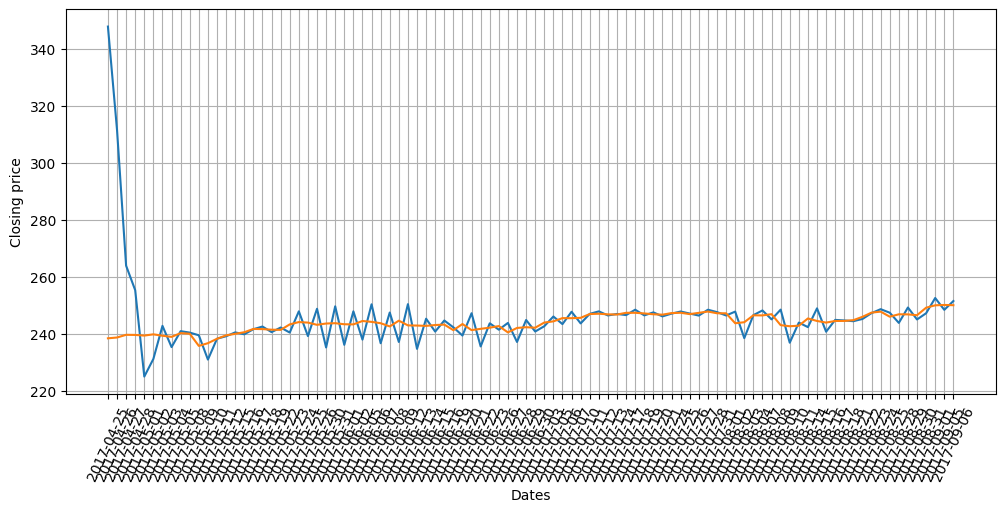

In [58]:
plot_array(epochsDF[0], epochsDF["Labels"])

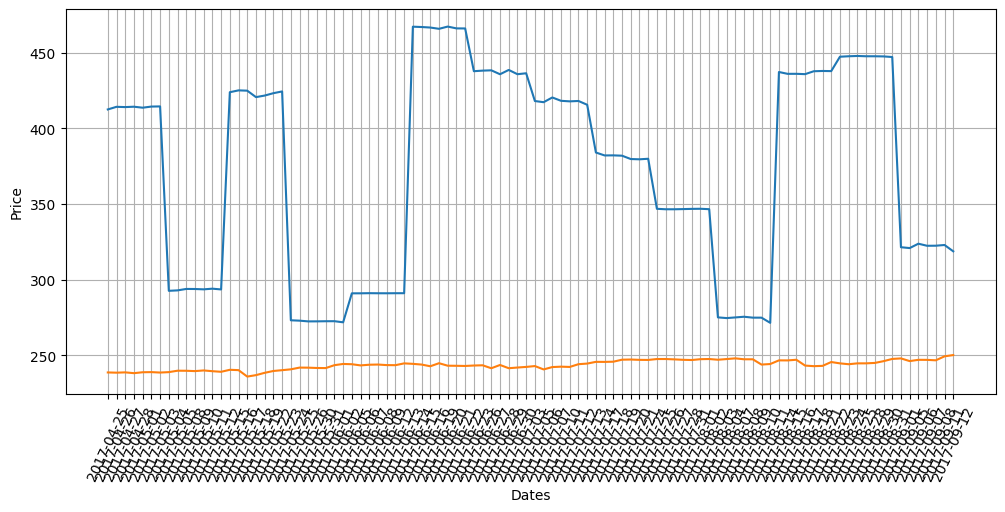

In [ ]:
plot_array(epochsDF[1], epochsDF["Labels"])

Could try normalizing params to 0-pi range, since now they seem to be way over the 0-3.14 rad radius after gradients are applied

print out average predictions and average labels to see if they're converging at all

VALIDATION (inference)

In [71]:
print(inputs_VALID[:5])

[[-0.78693673 -0.79400215 -0.78984138 -0.78787875 -0.78717223 -0.79243207
  -0.79203952]
 [-0.79400215 -0.78984138 -0.78787875 -0.78717223 -0.79243207 -0.79203952
  -0.79604336]
 [-0.78984138 -0.78787875 -0.78717223 -0.79243207 -0.79203952 -0.79604336
  -0.79486571]
 [-0.78787875 -0.78717223 -0.79243207 -0.79203952 -0.79604336 -0.79486571
  -0.78725069]
 [-0.78717223 -0.79243207 -0.79203952 -0.79604336 -0.79486571 -0.78725069
  -0.78489551]]


In [84]:
inputs_VALID[50]

array([-0.70631191, -0.70733227, -0.68660701, -0.68786313, -0.66980677,
       -0.67412471, -0.67663669])

In [82]:
labels_VALID[157]

263.190002

In [75]:
def inference(model, seven_day_vec, maxmin):
  print(f"Seven day data: {seven_day_vec}")

  prediction = postprocess_output(model.forward(seven_day_vec), maxmin[0], maxmin[1])
  
  print(f"Prediction for the eight day: {prediction}")

  return prediction

In [83]:
output = inference(trained_model, inputs_VALID[50], data_maxmin)

Seven day data: [-0.70631191 -0.70733227 -0.68660701 -0.68786313 -0.66980677 -0.67412471
 -0.67663669]
Prediction for the eight day: 259.52790489735946


In [ ]:
params_1d = np.reshape(theta_gamma_params, -1)
e_vec = np.zeros(len(params_1d))
e_vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [ ]:
theta_gamma_params

array([[0.88220813, 1.05991204, 1.46680408, 2.15098491],
       [2.90851839, 1.03002548, 1.72818114, 2.30659077],
       [0.39394578, 2.09449693, 1.2806631 , 2.33098704],
       [1.79428738, 1.14440894, 1.56955949, 2.6666867 ],
       [1.69497222, 1.01184316, 1.28220669, 1.50586418],
       [2.42397432, 1.25885186, 1.23701419, 1.7539721 ]])

In [ ]:
np.reshape(params_1d, (6, 4))

array([[0.88220813, 1.05991204, 1.46680408, 2.15098491],
       [2.90851839, 1.03002548, 1.72818114, 2.30659077],
       [0.39394578, 2.09449693, 1.2806631 , 2.33098704],
       [1.79428738, 1.14440894, 1.56955949, 2.6666867 ],
       [1.69497222, 1.01184316, 1.28220669, 1.50586418],
       [2.42397432, 1.25885186, 1.23701419, 1.7539721 ]])

In [ ]:
params = np.array([[1, 2, 3],[4, 5, 6]])

gradient_descent(params, 0)

[[1 2 3]
 [4 5 6]]
[1.001 2.    3.    4.    5.    6.   ]
[0.999 2.    3.    4.    5.    6.   ]
[1 2 3 4 5 6]
[1.    2.001 3.    4.    5.    6.   ]
[1.    1.999 3.    4.    5.    6.   ]
[1 2 3 4 5 6]
[1.    2.    3.001 4.    5.    6.   ]
[1.    2.    2.999 4.    5.    6.   ]
[1 2 3 4 5 6]
[1.    2.    3.    4.001 5.    6.   ]
[1.    2.    3.    3.999 5.    6.   ]
[1 2 3 4 5 6]
[1.    2.    3.    4.    5.001 6.   ]
[1.    2.    3.    4.    4.999 6.   ]
[1 2 3 4 5 6]
[1.    2.    3.    4.    5.    6.001]
[1.    2.    3.    4.    5.    5.999]
[1 2 3 4 5 6]


In [ ]:
QRNN_model = QRNN()
qc, model = QRNN_model.forward(inputs)

In [ ]:
qc

array([-0.25984296, -0.19762551, -0.23026206, -0.02800841, -0.12198073,
        0.2522841 ,  0.10216996])

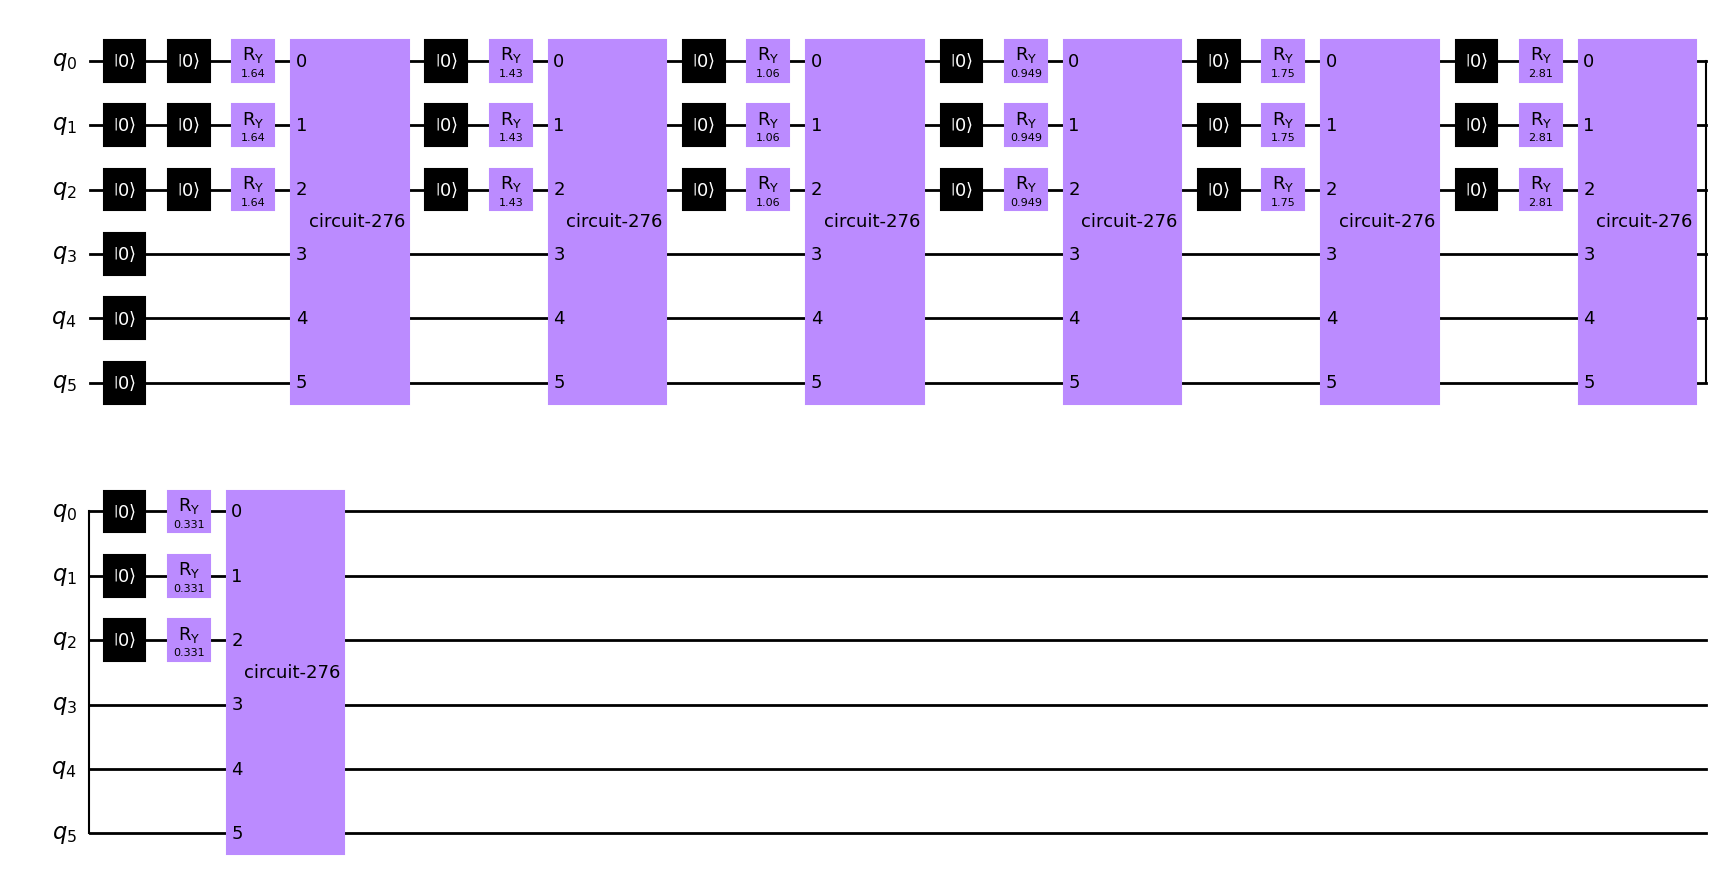

In [ ]:
model.draw("mpl")

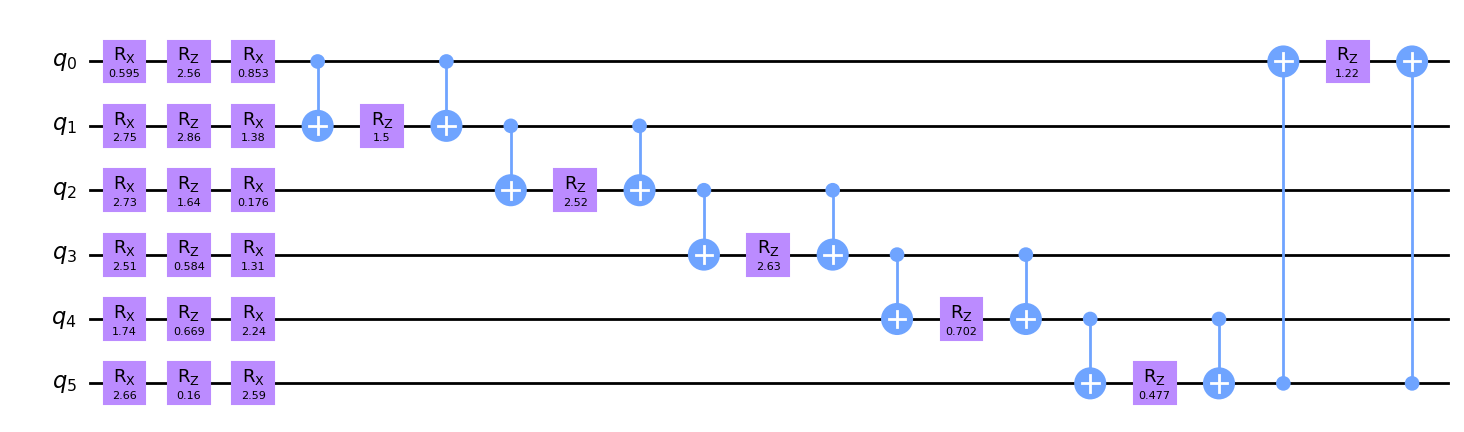

In [ ]:
ans = QRNN_model.construct_ansatz()
ans.draw("mpl")

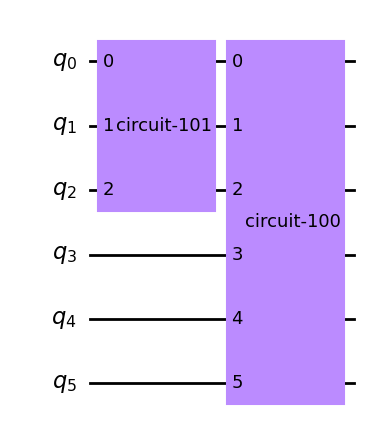

In [ ]:
qc.draw('mpl')

In [ ]:
import numpy as np

# x = 128.54
x = np.array([1, 3, 4, 5, -1, -7])
# goal : range [0, 1]
#NORMALIZATION FORMULA from https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
x1 = ((x - min(x)) / ( max(x) - min(x)))*2-1
print(x1)
# math.acos(x)
# print(math.acos(x))

# print(math.acos(0.55))


[ 0.33333333  0.66666667  0.83333333  1.          0.         -1.        ]


In [ ]:
rng = np.random.default_rng()
weights = rng.uniform(-1, 1, size=(6, 3))

In [ ]:
weights[]

array([[-0.68669286, -0.59068147, -0.94100421],
       [-0.52644754,  0.58167242, -0.14022919],
       [ 0.19528282,  0.08767172, -0.97406722],
       [-0.29248123,  0.09339544,  0.51187105],
       [-0.70119153,  0.19938807,  0.96372905],
       [-0.93182738,  0.55379874,  0.73056861]])

In [ ]:
weights[0][0]

-0.6866928594082833

In [ ]:
gamma_params = np.arccos(rng.uniform(-1, 1, size=(6, 1)))

In [ ]:
gamma_params

array([[2.01756771],
       [2.00816587],
       [2.63754127],
       [1.96501209],
       [2.97102456],
       [2.59263829]])

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


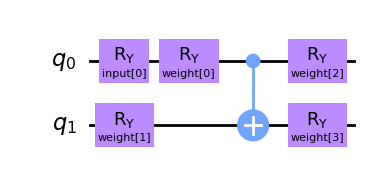

In [ ]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
# qc2.ry(inputs2[1], 1)
# qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")

In [ ]:
for idx in list(range(6)):
  print(idx, )

0
1
2
3
4
5


In [ ]:
range_list = list(range(1, 6))

In [ ]:
range_list.append(0)

In [ ]:
new_list = range_list.append(range_list.pop(0))

In [ ]:
range_list

[1, 2, 3, 4, 5, 0]

In [ ]:
new_list

In [ ]:
for idx in range_list:
  print(f"Regular id: {idx}, rolled idx: {range_list[idx]}")

Regular id: 0, rolled idx: 0
Regular id: 1, rolled idx: 1
Regular id: 2, rolled idx: 2
Regular id: 3, rolled idx: 3
Regular id: 4, rolled idx: 4
Regular id: 5, rolled idx: 5


In [ ]:
list(range(3*2))[1:]

[1, 2, 3, 4, 5]

In [ ]:
circuit = QuantumCircuit(3, 2)

# Add a H gate on qubit 0
circuit.h(0)
circuit.h(0)
circuit.h(1)
circuit.h(2)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
# circuit.ch(1, 0)

# circuit.h(2)

# circuit.ch(2, 0)

circuit.draw()

┌───┐┌───┐
q_0: ┤ H ├┤ H ├
     ├───┤└───┘
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     └───┘     
c: 2/══════════

In [ ]:
def fun(circuit):
  circ_dens_matrix = qi.DensityMatrix.from_instruction(circuit)
  qubits_to_trace_out = list(range(3))[1:]

  measured_qubit_rho = qi.partial_trace(circ_dens_matrix, qubits_to_trace_out)

  ket1 = qi.Statevector([1, 0])
  projector1 = ket1.to_operator()

  trimmed_measured_qubit_rho = measured_qubit_rho.evolve(projector1)
  return trimmed_measured_qubit_rho.trace()


In [ ]:
y_t = fun(circuit)

In [ ]:
abs(y_t)

0.9999999999999993

In [ ]:
# importing "cmath" for complex number operations
import cmath
 
# Initializing real numbers
x = 5
y = 3
 
# converting x and y into complex number
z = complex(x,y);

In [ ]:
z

(5+3j)

In [ ]:
abs(z)

5.830951894845301

In [ ]:
drive.flush_and_unmount() #save to drive when finishing work